In [136]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [137]:
consumption_data = pd.read_csv('finalized_files/consumption_temperature_data.csv')
temp_sleep_data = pd.read_csv('finalized_files/temperature_sleep_data.csv')
temp_tariff_data = pd.read_csv('finalized_files/temperature_tariff_data.csv')

In [138]:
consumption_data.drop(columns='Unnamed: 0', inplace=True)
temp_sleep_data.drop(columns='electricity_rate', inplace=True)

Ok so far I have completed the preprocessing of the datasets and I have three csv files. 

1. Consumption Data which has [time, consumption, cost, electricity_rate, indoor_temp, outdoor_temp] we have 288 rows
2. Temp_Tariff Data which has [time, electricity_rate, indoor temp, outdoor_temp] we have 8292 rows
3. Sleep_temp Data which has [time,  indoor temp, outdoor temp, sleep type] with 179 rows

____

## Data Analysis on Temp/Tariff Data

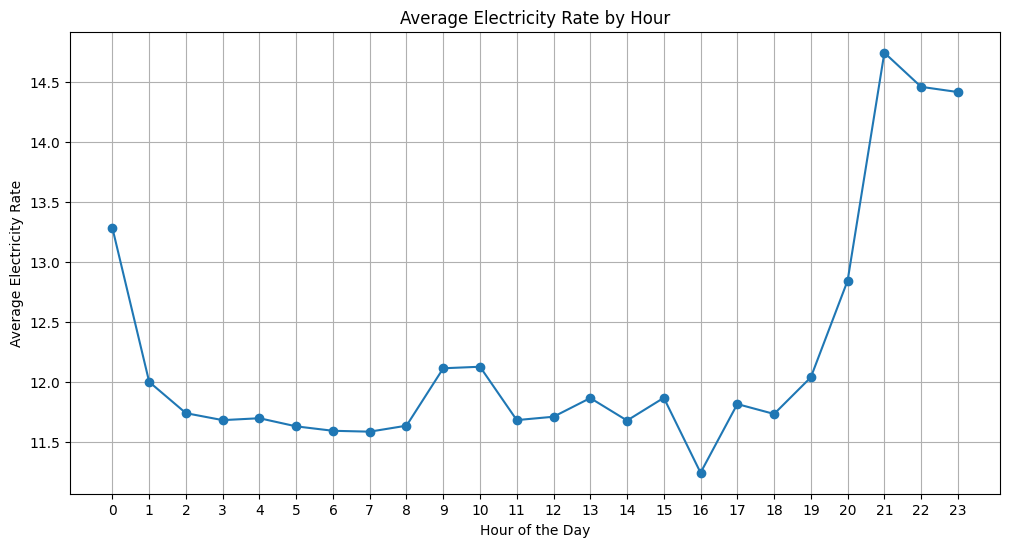

In [139]:
# Average hourly electricity rate
temp_tariff_data['time'] = pd.to_datetime(temp_tariff_data['time'])
hourly_rate = temp_tariff_data.groupby(temp_tariff_data['time'].dt.hour)['electricity_rate'].mean()
plt.figure(figsize=(12,6))
plt.plot(hourly_rate.index, hourly_rate.values, marker='o')
plt.title('Average Electricity Rate by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Electricity Rate')
plt.xticks(range(0, 24))
plt.grid()
plt.show()

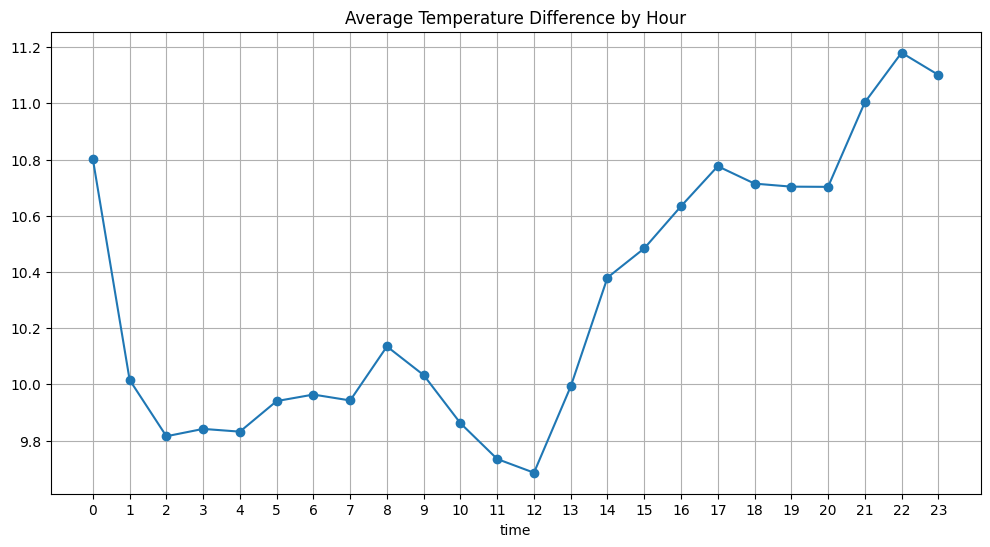

In [140]:
temp_tariff_data['temp_diff'] = temp_tariff_data['indoor_temp'] - temp_tariff_data['outdoor_temp']
plt.figure(figsize=(12,6))
temp_tariff_data.groupby(temp_tariff_data['time'].dt.hour)['temp_diff'].mean().plot(title='Average Temperature Difference by Hour', marker='o')
plt.xticks(range(0, 24))
plt.grid()
plt.show()


In [141]:
# Identify peak hours for electricity
peak_hours = temp_tariff_data[temp_tariff_data['electricity_rate'] == temp_tariff_data['electricity_rate'].max()]
# print(peak_hours)

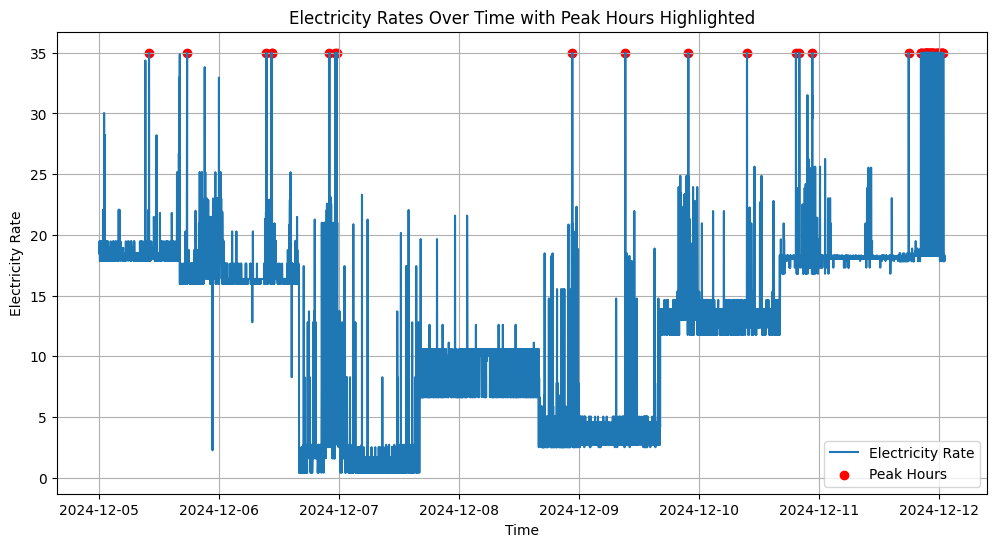

In [142]:
plt.figure(figsize=(12,6))
plt.plot(temp_tariff_data['time'], temp_tariff_data['electricity_rate'], label='Electricity Rate')
plt.scatter(peak_hours['time'], peak_hours['electricity_rate'], color='red', label='Peak Hours')
plt.legend()
plt.title('Electricity Rates Over Time with Peak Hours Highlighted')
plt.xlabel('Time')
plt.ylabel('Electricity Rate')
plt.grid()
plt.show()

____

## Data Analysis on Consumption Data

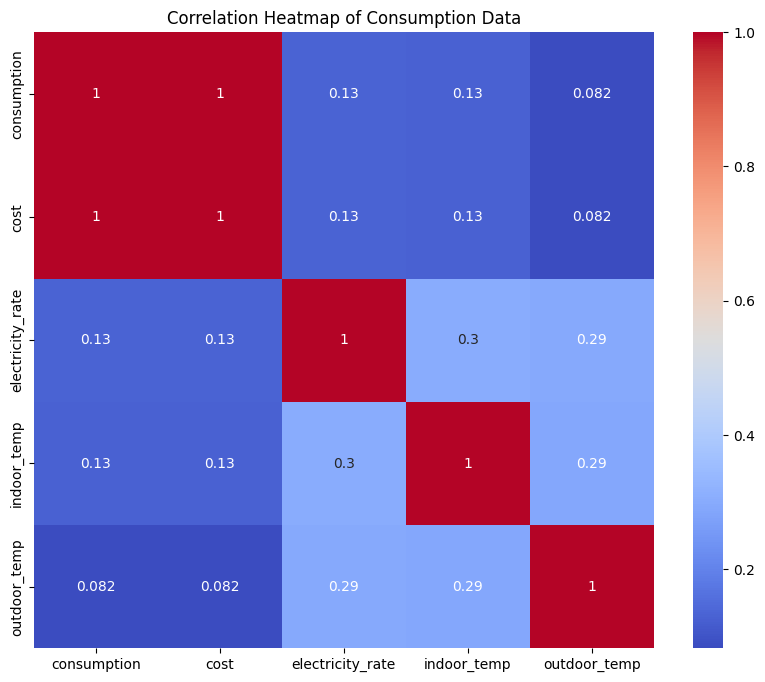

In [143]:
# Correlation matrix for consumption data
corr_matrix = consumption_data.drop(columns='time').corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Consumption Data')
plt.show()

What we can see from the correlation matrix above is that there is a slight correlation of 0.3 between outdoor temperature and the electricity rate which makes intuitive sense since as the temperature changes so does the heating and air conditioning of homes. The other interesting insight is that my own consumption and the temperature do not have a high correlation which might show that the apartment has good insulation and hence my heating does not get turned on as it gets colder outside. 

In [144]:
consumption_data.keys()
consumption_data['time'] = pd.to_datetime(consumption_data['time'])

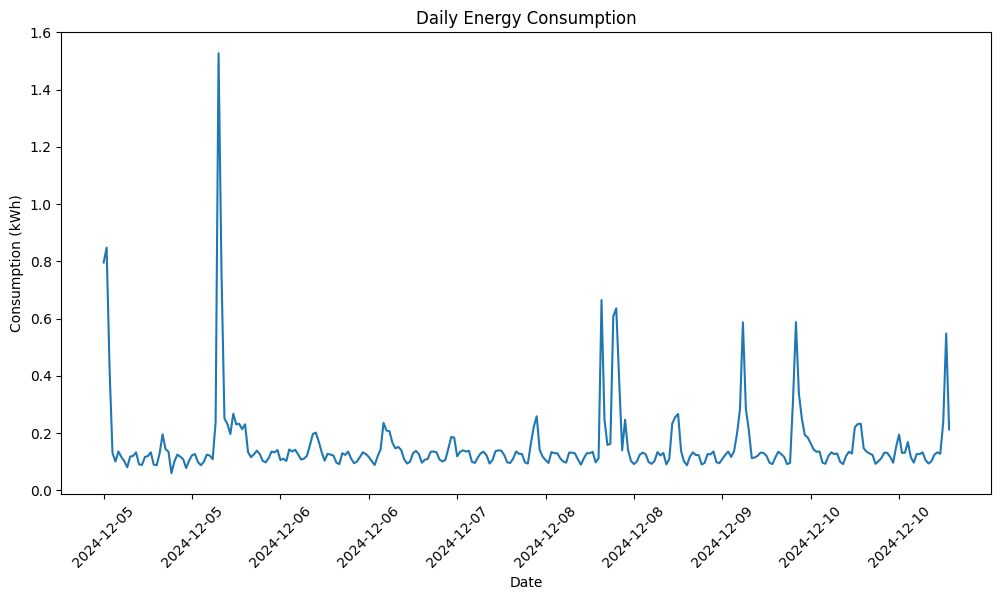

In [145]:
# Analysing energy consumption patterns
plt.figure(figsize=(12,6))
plt.plot(consumption_data['time'], consumption_data['consumption'])
plt.title('Daily Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.xticks(consumption_data['time'][::30], rotation=45)
plt.show()

In [146]:
# Get the average hourly consumption of electricity 
average_hourly_consumption= consumption_data.groupby(consumption_data['time'].dt.hour)['consumption'].mean()

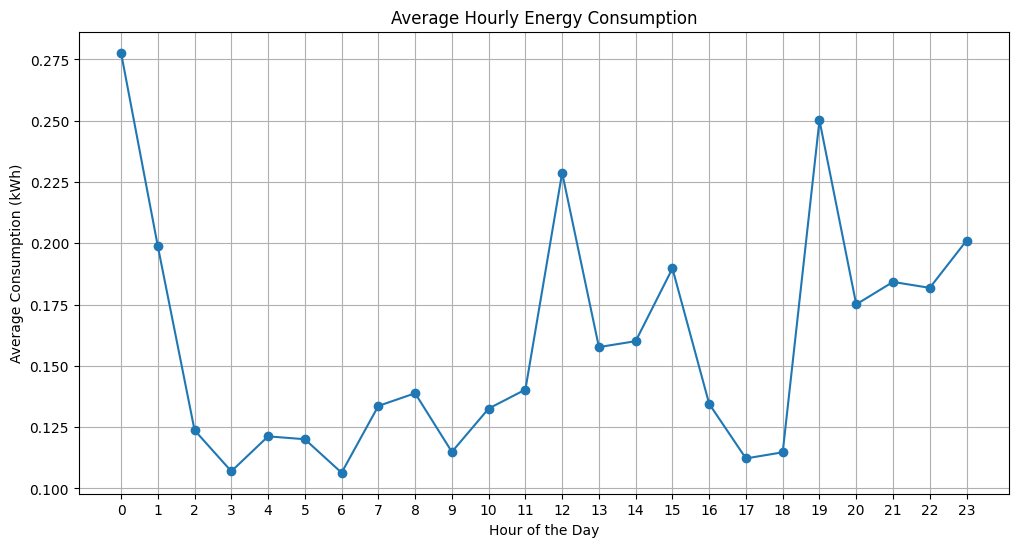

In [147]:
plt.figure(figsize=(12,6))
plt.plot(average_hourly_consumption.index, average_hourly_consumption.values, marker='o')
plt.title('Average Hourly Energy Consumption')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Consumption (kWh)')
plt.xticks(range(0, 24))
plt.grid()
plt.show()

___

## Data Analysis for Sleep Temp Data

In [148]:
temp_sleep_data['time'] = pd.to_datetime(temp_sleep_data['time'])

In [91]:
avg_temps = temp_sleep_data.groupby('sleep_type')[['indoor_temp', 'outdoor_temp']].mean()

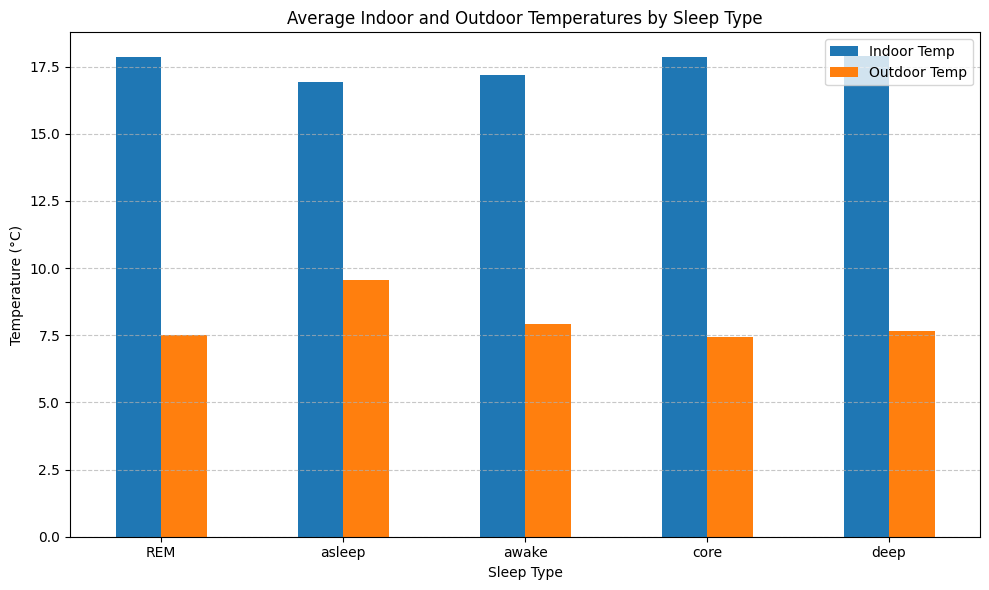

In [92]:
# Bar plot for average temperatures
avg_temps.plot(kind='bar', figsize=(10, 6))
plt.title('Average Indoor and Outdoor Temperatures by Sleep Type')
plt.ylabel('Temperature (°C)')
plt.xlabel('Sleep Type')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(['Indoor Temp', 'Outdoor Temp'])
plt.tight_layout()
plt.show()

In [93]:
temp_sleep_data['temp_diff'] = temp_sleep_data['indoor_temp'] - temp_sleep_data['outdoor_temp']
avg_temp_diff = temp_sleep_data.groupby('sleep_type')['temp_diff'].mean()

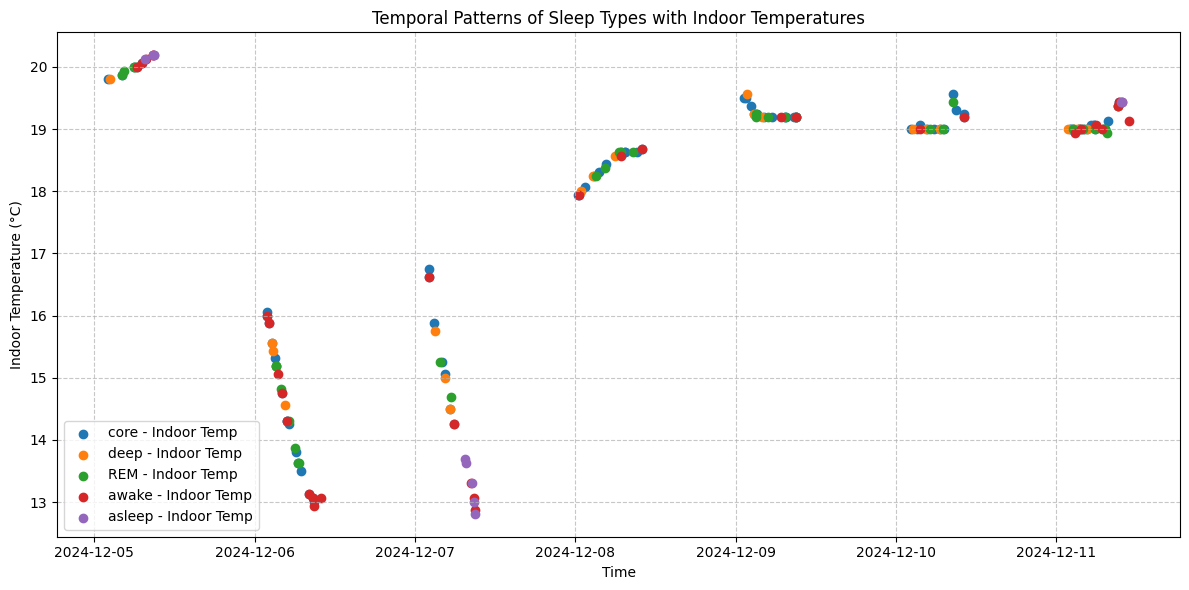

In [95]:
plt.figure(figsize=(12, 6))
for sleep_type in temp_sleep_data['sleep_type'].unique():
    sleep_data = temp_sleep_data[temp_sleep_data['sleep_type'] == sleep_type]
    plt.scatter(sleep_data['time'], sleep_data['indoor_temp'], label=f'{sleep_type} - Indoor Temp')

plt.title('Temporal Patterns of Sleep Types with Indoor Temperatures')
plt.ylabel('Indoor Temperature (°C)')
plt.xlabel('Time')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

____

## Advanced Analysis and Modeling

In [168]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
# Fit the data to a Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = temp_tariff_data[['indoor_temp', 'outdoor_temp']]
y = temp_tariff_data['electricity_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train, y_train)
y_pred = dt_regressor.predict(X_test)

print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R2 Score: {r2_score(y_test, y_pred)}')

Mean Squared Error: 9.187548780707555
R2 Score: 0.7996523433065247


In [180]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define the parameter grid
param_grid = {
    'max_depth': np.arange(3, 20, 1),
    'min_samples_leaf': [1, 2, 4, 6, 8, 10]
}

# Initialize the DecisionTreeRegressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dt_regressor, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best Score: {best_score}')

Best Parameters: {'max_depth': 19, 'min_samples_leaf': 1}
Best Score: 0.7865341911467001


In [181]:
from sklearn.metrics import r2_score

# Calculate the out-of-sample R² score
out_of_sample_r2 = r2_score(y_test, y_pred)
print(f'Out-of-Sample R² Score: {out_of_sample_r2}')

Out-of-Sample R² Score: 0.7996523433065247


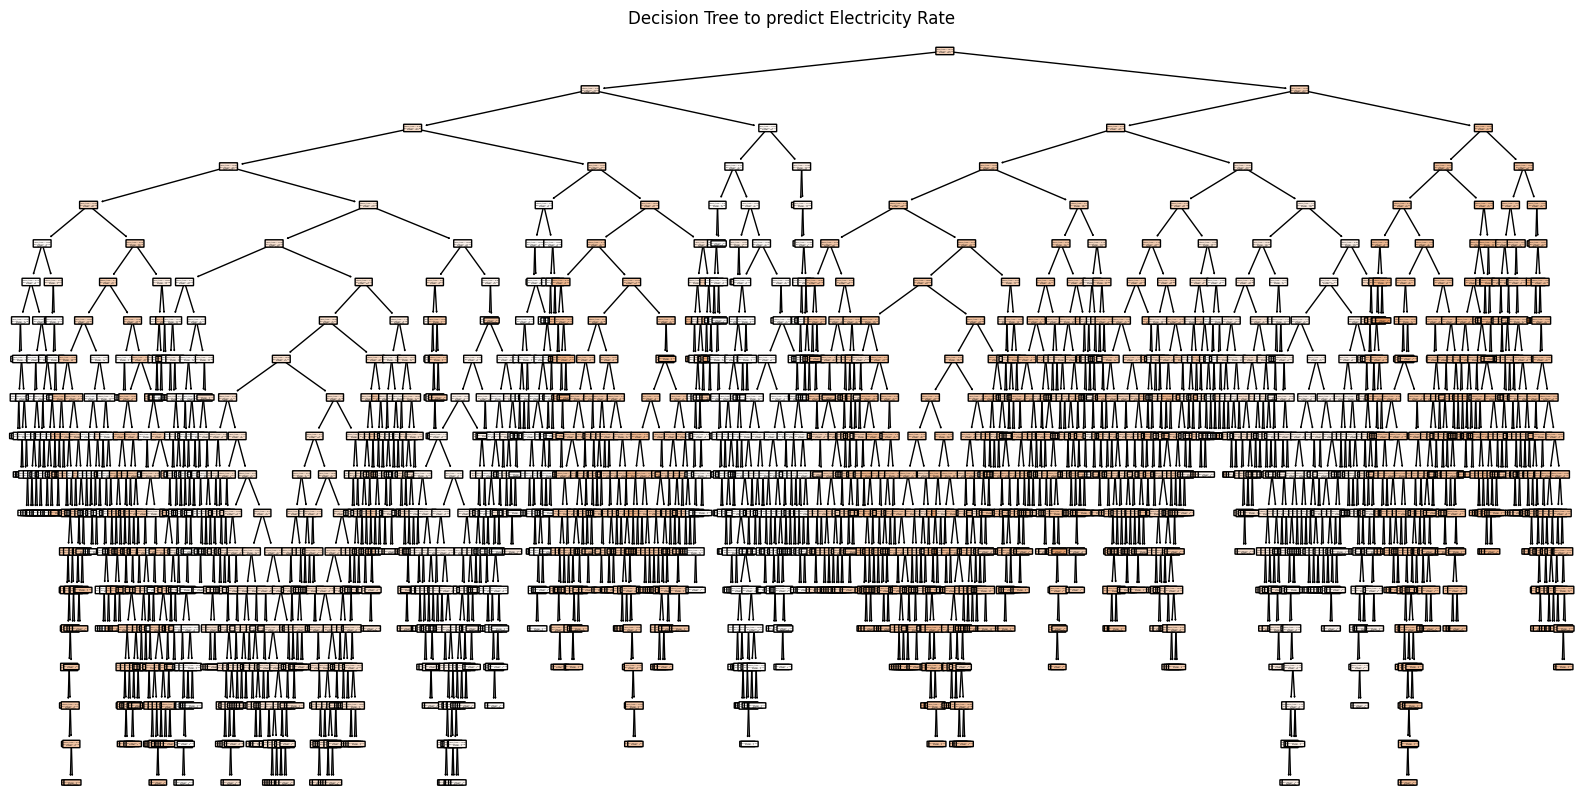

In [184]:
from sklearn.tree import plot_tree

# Plot the best decision tree
plt.figure(figsize=(20, 10))
plot_tree(grid_search.best_estimator_, feature_names=X.columns, filled=True, rounded=True)
plt.title('Decision Tree to predict Electricity Rate')
plt.show()

In [183]:
# Get feature importances
importances = grid_search.best_estimator_.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)

        Feature  Importance
0   indoor_temp    0.556711
1  outdoor_temp    0.443289
